In [1]:
import pandas as pd

In [2]:
data_size = str(50)

In [3]:
def load_sparql_results(system, data_size):
    sparql_times = f"/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/gmark_50_new/mix/results/{system}/{data_size}/times_{system}.csv"
    df_sparql = pd.read_csv(sparql_times)
    df_sparql_agg = df_sparql.groupby('query')[['load_time', 'exec_time']].mean().reset_index()
    df_sparql_agg['total_time'] = df_sparql_agg['load_time'] + df_sparql_agg['exec_time']
    df_sparql_agg['nr'] = df_sparql_agg['query'].str.slice(len("query-"), -len(".sparql"))
    return df_sparql_agg

In [36]:
def load_n3_times(type, data_size):
    n3_times = f"/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/gmark_50_new/mix/n3/results/{data_size}/times_n3.csv"
    df_n3 = pd.read_csv(n3_times)
    
    df_n3 = df_n3[df_n3['type']==type]
    
    df_n3['id'] = df_n3.apply(lambda x: f"{x['query']},{x['type']}", axis=1)
    df_n3_failed = df_n3[df_n3['reas_time']==-1]['id']
    df_n3_filt = df_n3[~df_n3['id'].isin(df_n3_failed)]
    
    df_n3_total = df_n3_filt[df_n3_filt['phase'].isna() | (df_n3_filt['phase']=='total')]
    df_n3_agg = df_n3_total.groupby('query')[['netw_time', 'reas_time']].mean().reset_index()
    
    df_n3_agg['total_time'] = df_n3_agg['netw_time'] + df_n3_agg['reas_time']
    
    df_n3_agg['nr'] = df_n3_agg['query'].str.slice(len("query-"), -len(".n3"))
    
    return df_n3_agg

In [5]:
df_sparql_rdflib = load_sparql_results('rdflib', data_size)
df_sparql_rdflib['total_time'].describe()

count       50.000000
mean      1896.074385
std      10278.937480
min          6.066459
25%         12.385252
50%         41.683662
75%        405.740373
max      72760.907392
Name: total_time, dtype: float64

In [18]:
df_sparql_jena = load_sparql_results('jena', data_size)
df_sparql_jena['total_time'].describe()

count      50.000000
mean      322.688000
std       467.581048
min       201.600000
25%       214.500000
50%       230.400000
75%       268.500000
max      3519.000000
Name: total_time, dtype: float64

In [37]:
df_n3_dir = load_n3_times('direct', data_size)
df_n3_dir['total_time'].describe()

count        41.000000
mean       5292.463415
std       25057.307898
min           9.000000
25%          13.000000
50%          38.000000
75%         331.000000
max      155842.000000
Name: total_time, dtype: float64

In [27]:
df_n3_bwd = load_n3_times('bwd', data_size)
df_n3_bwd['total_time'].describe()

count       41.000000
mean      1799.536585
std       7504.091931
min         46.000000
25%         79.000000
50%         98.000000
75%        177.000000
max      44197.000000
Name: total_time, dtype: float64

In [28]:
df_n3_fwd = load_n3_times('fwd', data_size)
df_n3_fwd['total_time'].describe()

count     50.000000
mean     132.800000
std       96.937615
min       50.200000
25%       87.350000
50%      104.400000
75%      145.300000
max      694.200000
Name: total_time, dtype: float64

In [47]:
import matplotlib.pyplot as plt

def plot_systems(lim=None, incl_only=['n3_dir', 'n3_bwd', 'n3_fwd','jena', 'rdflib']):
    fig, ax = plt.subplots()
    if lim is not None:
        ax.set_ylim(0, lim)

    if 'n3_bwd' in incl_only:
        df_n3_bwd.plot(x='nr', y='reas_time', ax=ax, label='bwd')
    if 'n3_fwd' in incl_only:
        df_n3_fwd.plot(x='nr', y='reas_time', ax=ax, label='fwd')
    if 'n3_dir' in incl_only:
        df_n3_dir.plot(x='nr', y='reas_time', ax=ax, label='direct')

    if 'jena' in incl_only:
        df_sparql_jena.plot(x='nr', y='exec_time', ax=ax, label='jena')
    if 'rdflib' in incl_only:
        df_sparql_rdflib.plot(x='nr', y='exec_time', ax=ax, label='rdflib')

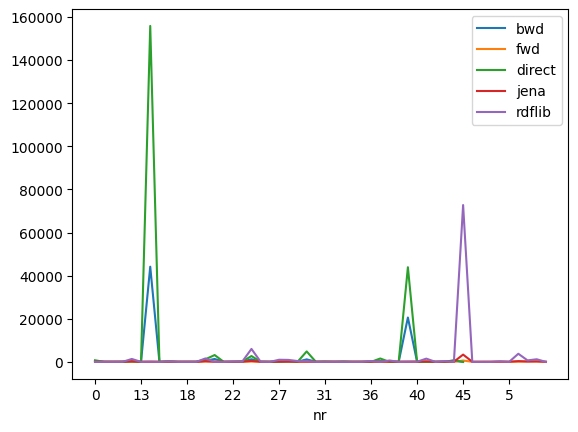

In [48]:
plot_systems()

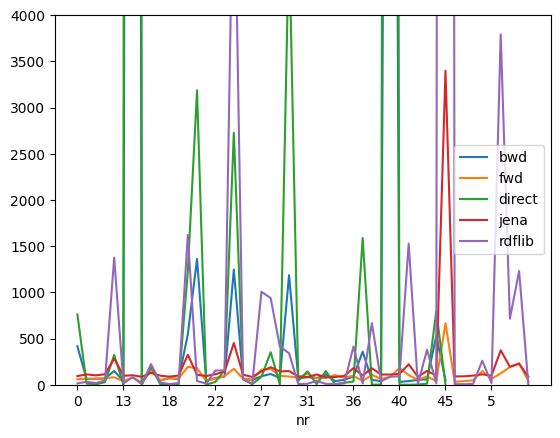

In [49]:
plot_systems(4000)

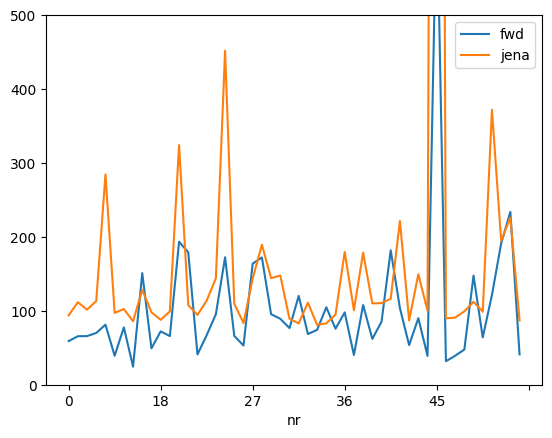

In [54]:
plot_systems(500, ['n3_fwd', 'jena'])